In [1]:
import sys
sys.path.append('../..')

from common.toronto_api import TorontoOpenDataAPI
import ferry_tickets.src.ferry_analysis as an

import pandas as pd
from datetime import datetime
from pprint import pprint

In [2]:
# Initialize API client
client = TorontoOpenDataAPI()


In [3]:

# Get package metadata using dataset id
package = client.get_package("toronto-island-ferry-ticket-counts")

In [4]:
pprint(package)

{'author': 'pfr.researchanalytics@toronto.ca',
 'author_email': 'pfr.researchanalytics@toronto.ca',
 'creator_user_id': 'e4bf44e1-1a0c-434f-acec-339703a20ce6',
 'dataset_category': 'Table',
 'date_published': '2024-03-06 12:39:40.281513',
 'excerpt': 'This dataset provides near real-time information about Toronto '
            'Island ferry ticket sales and ticket redemptions. ',
 'formats': 'JSON,CSV,XML',
 'groups': [],
 'id': 'toronto-island-ferry-ticket-counts',
 'information_url': 'https://www.toronto.ca/explore-enjoy/parks-gardens-beaches/toronto-island-park/ferries-to-toronto-island-park/',
 'is_retired': 'false',
 'isopen': False,
 'last_refreshed': '2024-10-30 15:17:41.754479',
 'license_id': 'notspecified',
 'license_title': 'License not specified',
 'maintainer': None,
 'maintainer_email': 'pfr.researchanalytics@toronto.ca',
 'metadata_created': '2024-03-06T19:56:20.096755',
 'metadata_modified': '2024-10-30T15:17:43.723995',
 'name': 'toronto-island-ferry-ticket-counts',
 '

In [5]:
print(f'Number of resources: {package["num_resources"]}\n')
for idx, resource in enumerate(package["resources"]):
    print(f'''{idx}: {resource["name"]}
    Active: {resource["datastore_active"]}
    url type: {resource["url_type"]}
''')

Number of resources: 4

0: Toronto Island Ferry Ticket Counts
    Active: True
    url type: datastore

1: Toronto Island Ferry Ticket Counts.csv
    Active: False
    url type: upload

2: Toronto Island Ferry Ticket Counts.xml
    Active: False
    url type: upload

3: Toronto Island Ferry Ticket Counts.json
    Active: False
    url type: upload



In [6]:
# Get resource data:
for idx, resource in enumerate(package["resources"]):

    # To get data from cached csv:
    if not resource["datastore_active"] and resource['format']=='CSV':
        print(f'**getting data from cached csv**')
        print(f'\t{resource["url"]}')
        df = pd.read_csv(resource["url"])

df.head()

**getting data from cached csv**
	https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/toronto-island-ferry-ticket-counts/resource/c46719f5-8006-44e1-8b1e-5ad90bb9f6f4/download/toronto-island-ferry-ticket-counts.csv


,_id,Timestamp,Redemption Count,Sales Count
0,1,2024-10-30T10:45:00,151,152
1,2,2024-10-30T10:30:00,59,43
2,3,2024-10-30T10:15:00,26,25
3,4,2024-10-30T10:00:00,10,19
4,5,2024-10-30T09:45:00,12,17


In [7]:
# Parse Timestamp as datetime obj
df['datetimeTimestamp'] = pd.to_datetime(
    df['Timestamp'],
    format="%Y-%m-%dT%H:%M:%S"
)
# Get latest date
latest = max(df['datetimeTimestamp']).date()
print(f"latest:\t{latest}")
# Get today's date
today = datetime.today().date()
print(f"today:\t{today}")

# Checking if the date part of timestamp is the same as today and latest date, add as df columns
df['isToday'] = today == df['datetimeTimestamp'].dt.date
df['isLatest'] = latest == df['datetimeTimestamp'].dt.date


latest:	2024-10-30
today:	2024-10-30


In [8]:

# View
df.head()

,_id,Timestamp,Redemption Count,Sales Count,datetimeTimestamp,isToday,isLatest
0,1,2024-10-30T10:45:00,151,152,2024-10-30 10:45:00,True,True
1,2,2024-10-30T10:30:00,59,43,2024-10-30 10:30:00,True,True
2,3,2024-10-30T10:15:00,26,25,2024-10-30 10:15:00,True,True
3,4,2024-10-30T10:00:00,10,19,2024-10-30 10:00:00,True,True
4,5,2024-10-30T09:45:00,12,17,2024-10-30 09:45:00,True,True


In [9]:
# Add time-based features
df['month'] = df['datetimeTimestamp'].dt.month
df['year'] = df['datetimeTimestamp'].dt.year
df['season'] = pd.cut(
    df['datetimeTimestamp'].dt.month, 
    bins=[0,3,6,9,12], 
    labels=['Winter', 'Spring', 'Summer', 'Fall']
)
df['hour'] = df['datetimeTimestamp'].dt.hour
df['day_of_week'] = df['datetimeTimestamp'].dt.day_name()


In [10]:
# Update saved csv
df.to_csv(
    '../data/processed/Toronto Island Ferry Ticket Counts.csv',
    header=True,
    index=False
)


---


In [11]:
# Use script to generate analyses
analyses = an.analyze_ferry_patterns(df)


/Users/taniab/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/taniab/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


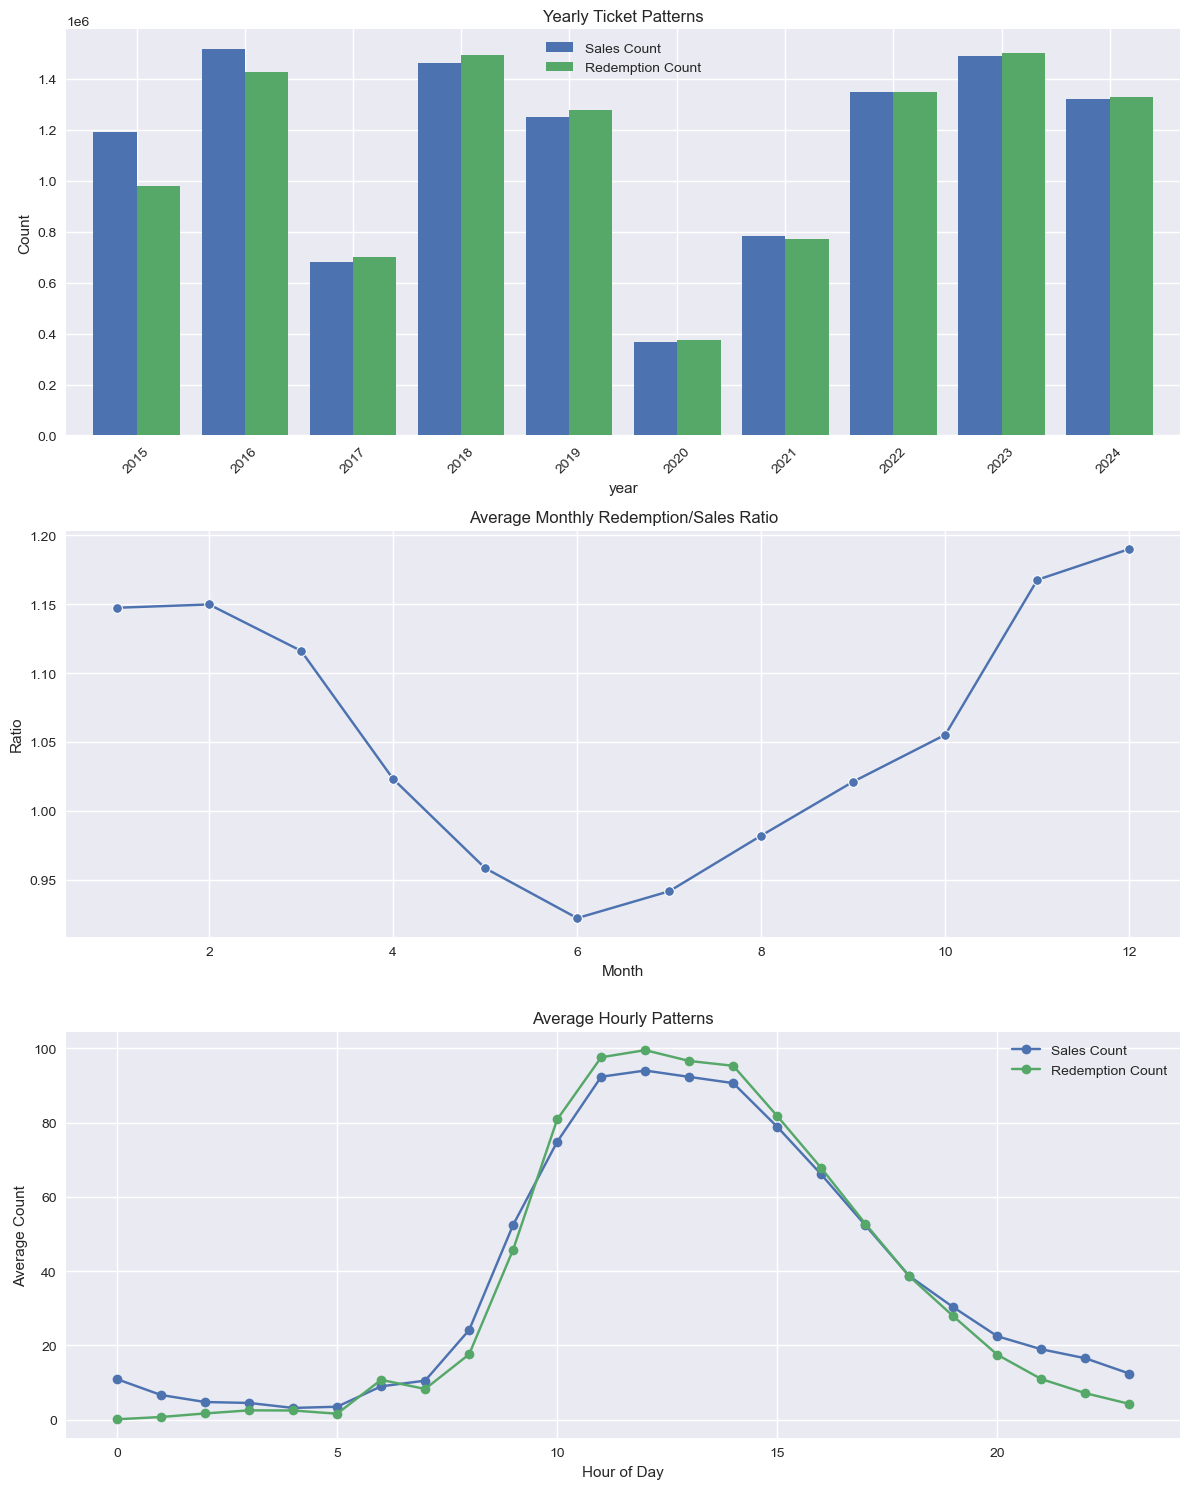

In [12]:
fig1 = an.plot_patterns(analyses)


In [13]:
insights = an.generate_insights(analyses)
insights

{'years_with_excess_redemptions': [2017, 2018, 2019, 2020, 2022, 2023, 2024],
 'max_redemption_ratio': {'value': 1.0242032634469902, 'year': 2017},
 'avg_monthly_ratio': 1.0522189412021747,
 'peak_hour': {'redemptions': 12, 'sales': 12}}

In [14]:

# Create monthly aggregations
monthly_stats = df.groupby(['year', 'month'], observed=True).agg({
    'Sales Count': 'sum',
    'Redemption Count': 'sum'
}).reset_index()

# Calculate monthly averages by season
seasonal_patterns = df.groupby(['season', 'month'], observed=True).agg({
    'Sales Count': 'mean',
    'Redemption Count': 'mean'
}).round(2)

In [15]:
# Peak usage analysis by season
seasonal_hourly = df.groupby(['season', 'hour'], observed=True).agg({
    'Sales Count': 'mean',
    'Redemption Count': 'mean'
}).round(2)

# Find peak hours for each season
peak_hours = seasonal_hourly.groupby('season', observed=True)['Redemption Count'].idxmax()

In [16]:
# Calculate year-over-year growth
yearly_stats = df.groupby('year')[['Sales Count', 'Redemption Count']].sum()
yearly_growth = yearly_stats.pct_change() * 100

In [17]:
# Calculate YoY growth for each month
monthly_stats['previous_year_sales'] = monthly_stats.groupby('month')['Sales Count'].shift(1)
monthly_stats['yoy_growth'] = ((monthly_stats['Sales Count'] - monthly_stats['previous_year_sales']) 
                              / monthly_stats['previous_year_sales'] * 100).round(2)

In [18]:
yearly_stats

,Sales Count,Redemption Count
year,,
2015,1189620,978707
2016,1518428,1425779
2017,682346,698861
2018,1463589,1493560
2019,1249725,1278505
2020,366606,374546
2021,782368,773040
2022,1346659,1349778
2023,1491473,1502883


In [19]:
yearly_growth

,Sales Count,Redemption Count
year,,
2015,NaN,NaN
2016,27.639751,45.679861
2017,-55.062341,-50.983918
2018,114.493673,113.713457
2019,-14.612299,-14.398819
2020,-70.665066,-70.704377
2021,113.408400,106.393874
2022,72.126033,74.606489
2023,10.753576,11.342976
